## Introduction

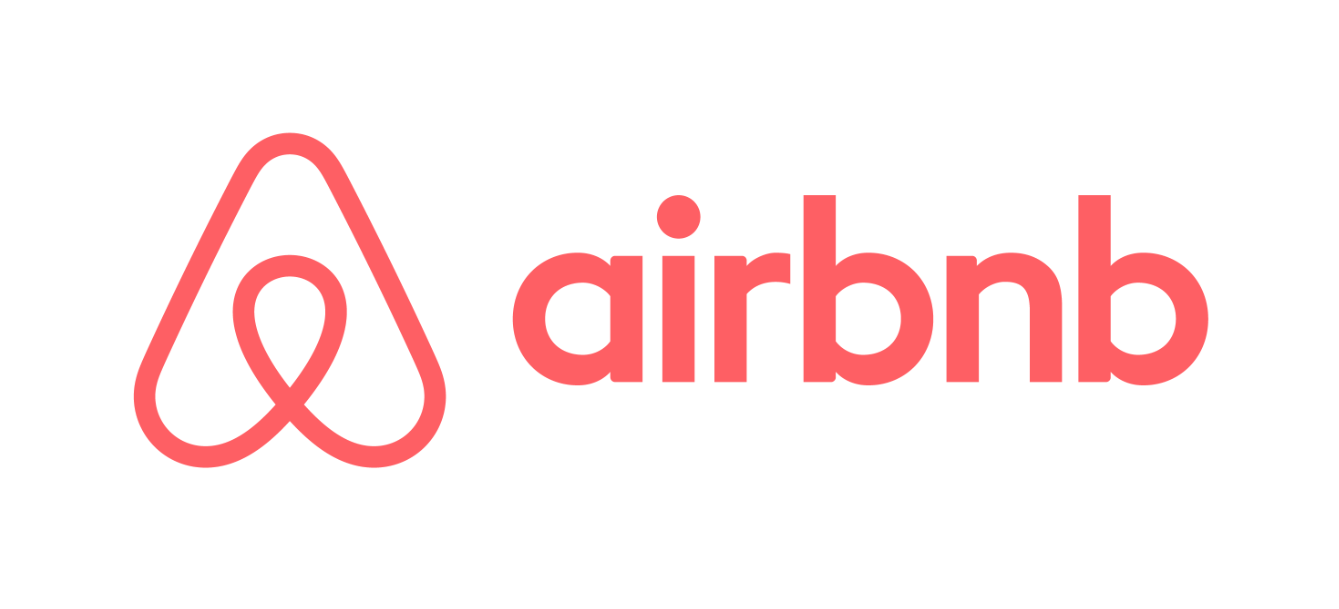

We will be developing different machine learning models to predict 
prices of Boston Airbnb rentals and then do a comparison between them.

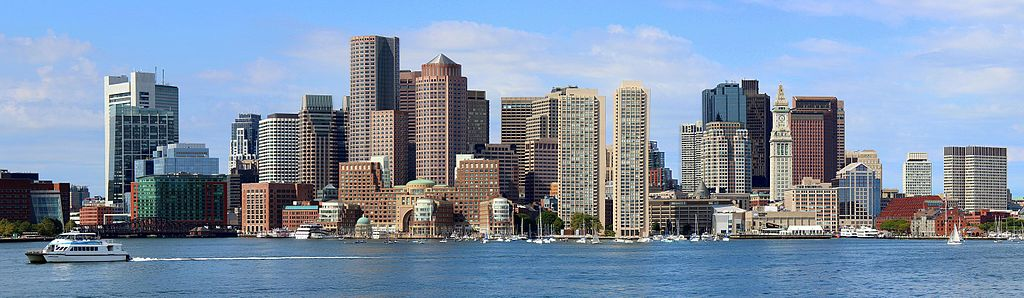

## Business Understanding
1. Comparison of price prediction model on Boston Airbnb dataset. 

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso,LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## Data Understanding

In this part we will load the data, check for missing values, and then clean the data for analysis if needed.


In [3]:
#Reading the csv file
df_list = pd.read_csv('listings.csv')

In [4]:
df_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [5]:
df_list.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [6]:
df_list.dtypes

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 95, dtype: object

## Data Preparation
We will be performing data processing in this part. This includes cleaning, type converting and other data manipulations.

In [7]:
#We will be using this class for data preprocessing
class Data_Handle:
    def __init__(self,df):
        super(Data_Handle,self).__init__()
        self.df = df
        
    def remove_columns(self,df,drop_cols):
        '''
        INPUT:
        df - the pandas dataframe from which columns has to be dropped
        drop_cols = list of column names that's need to be dropped
        
        OUTPUT:
        df - dataframe with the specified columns removed
        '''
        self.df = df.drop(drop_cols,axis=1)
        return self.df
    
    def print_top_x_missing_percent_cols(self,df,top_x):
        '''
        INPUT:
        df - the pandas dataframe whose percentage of missing value for each column has
        to be printed
        top_x = top x number of columns with most missing value percentage will be
        printed
        
        '''
        null_df = df.isnull().sum().sort_values(ascending=False)
        percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
        missing_data = pd.concat([null_df, percent], axis=1, keys=['Total', 'Percent'])
        print(missing_data.head(top_x))
        return
    
    def extract_numeric(self,df,columns):
        '''
        INPUT:
        df - the pandas dataframe from which numeric values need to be
        extracted from the specified columns having comma separated cell
        values.
        columns = list of column names from which values have to be 
        extracted
        
        OUTPUT:
        df - dataframe with numeric value extracted.
        '''
        remove_commas = lambda x:''.join(str(x).split(','))
        for col in columns:
            self.df[col] = df[col].apply(remove_commas).str.extract(r'(\d+)').astype(float)
        return self.df
    
    def convert_to_binary(self,df,columns):
        '''
        INPUT:
        df - the pandas dataframe from which columns has to be converted
        to binary
        
        OUTPUT:
        df - dataframe with the specified columns converted to binary
        '''
        for col in columns:
            self.df[col] = df[col].apply(lambda x: 1 if str(x)=='t' else 0 )
        return self.df
    
    def fill_missing_col(self,df,columns,method):
        '''
        INPUT:
        df - the pandas dataframe in which the specified column's
        missing values will be filled
        columns = list of column names that's need to be filled
        method = method used to fill the missing values.
        (median,mean,mode)
        OUTPUT:
        df - dataframe with the specified columns filled.
        '''
        for col in columns:
            if method=='mode':
                self.df[col] = df[col].fillna(df[col].mode()[0])
            elif method=='median':
                self.df[col] = df[col].fillna(df[col].median()[0])
            elif method=='mean':
                self.df[col] = df[col].fillna(df[col].mean())
        
        return self.df
    
    def convert_to_category(self,df,columns):
        '''
        INPUT:
        df - the pandas dataframe in which  the columns specified
        will be converted to category variables
        columns = list of column names that's need to be converted
        
        OUTPUT:
        df - dataframe with the specified columns converted to 
        categorical variables.
        '''
        for col in columns:
            df = pd.concat([df.drop(col,axis=1),pd.get_dummies(df[col],drop_first=False)],axis=1)
        self.df = df.copy()
        return self.df
    
    def list_feature_to_count(self,df,column_name,new_column_name):
        '''
        INPUT:
        df - the pandas dataframe from which the specifed column
        will be converted.
        Here a column having values as lists will be converted to
        count of values in the list
        For Ex column value x =['a','b'] this value will converted to 2
        column_name = single column name
        new_column_name = column name for the new values.
        
        OUTPUT:
        df - dataframe with the specified column converted.
        '''
        count_items_in_list = lambda x : len(x.split(',')) 
        self.df[new_column_name] = df[column_name].apply(count_items_in_list)
        self.df = df.drop(columns=[column_name])
        return self.df
            
    
    def remove_rows_missing_col(self,df,columns):
        '''
        INPUT:
        df - the pandas dataframe from which rows will be removed
        which have missing values in the specified columns
        columns = list of column names that's need to be checked
        for missing values.
        
        OUTPUT:
        df - dataframe with the rows removed
        '''
        for col in columns:
            self.df = df.dropna(col)
        return self.df

In [8]:
data = Data_Handle(df_list) #create of object of the class

In [9]:
#First we will fix numeric columns to be of int or float type
numeric_cols = ['extra_people','host_response_rate','host_acceptance_rate','price','monthly_price','weekly_price','security_deposit','cleaning_fee']
df_list = data.extract_numeric(df_list,numeric_cols)
df_list.dtypes

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 95, dtype: object

In [10]:
# this function prints percent of missing values of top m columns
data.print_top_x_missing_percent_cols(df_list,60)

                              Total   Percent
neighbourhood_group_cleansed   3585  1.000000
jurisdiction_names             3585  1.000000
license                        3585  1.000000
has_availability               3585  1.000000
square_feet                    3529  0.984379
monthly_price                  2697  0.752301
weekly_price                   2693  0.751185
security_deposit               2243  0.625662
notes                          1975  0.550907
interaction                    1554  0.433473
access                         1489  0.415342
neighborhood_overview          1415  0.394700
host_about                     1309  0.365132
transit                        1290  0.359833
house_rules                    1192  0.332497
cleaning_fee                   1107  0.308787
space                          1057  0.294840
review_scores_accuracy          823  0.229568
review_scores_location          822  0.229289
review_scores_value             821  0.229010
review_scores_checkin           82

In [11]:
# We will drop columns that have more than 30% data missing, columns 
# that have textual content like reviews, urls etc.
# drop columns
drop_cols=['listing_url','scrape_id','jurisdiction_names','license','thumbnail_url','medium_url',
           'picture_url','xl_picture_url','host_thumbnail_url','host_picture_url','state','has_availability',
           'neighbourhood_group_cleansed','notes','smart_location','country','country_code',
           'transit','latitude','longitude','last_scraped','access','interaction','neighborhood_overview',
           'host_about','house_rules','space','square_feet','last_review','first_review','host_id','host_url',
           'calendar_last_scraped','experiences_offered','id','monthly_price','weekly_price',
            'security_deposit']

In [12]:
df_list = data.remove_columns(df_list,drop_cols)
data.print_top_x_missing_percent_cols(df_list,60)

                                  Total   Percent
cleaning_fee                       1107  0.308787
review_scores_accuracy              823  0.229568
review_scores_location              822  0.229289
review_scores_value                 821  0.229010
review_scores_checkin               820  0.228731
review_scores_cleanliness           818  0.228173
review_scores_communication         818  0.228173
review_scores_rating                813  0.226778
reviews_per_month                   756  0.210879
neighbourhood                       543  0.151464
host_acceptance_rate                471  0.131381
host_response_rate                  471  0.131381
host_response_time                  471  0.131381
host_neighbourhood                  339  0.094561
summary                             143  0.039888
zipcode                              38  0.010600
market                               14  0.003905
bathrooms                            14  0.003905
host_location                        11  0.003068


Some columns need to be converted to binary(0-1) as they hold either t(true) or f(false)

In [13]:
#convert to binary columns
boolean_cols = ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact',
                'requires_license','instant_bookable','require_guest_profile_picture',
                'require_guest_phone_verification']

In [14]:
#We will fill missing values in the binary columns with most frequent value(mode)
#add missing values to binary columns with mode method
df_list = data.fill_missing_col(df_list,boolean_cols,'mode')
data.print_top_x_missing_percent_cols(df_list,60)

                                  Total   Percent
cleaning_fee                       1107  0.308787
review_scores_accuracy              823  0.229568
review_scores_location              822  0.229289
review_scores_value                 821  0.229010
review_scores_checkin               820  0.228731
review_scores_cleanliness           818  0.228173
review_scores_communication         818  0.228173
review_scores_rating                813  0.226778
reviews_per_month                   756  0.210879
neighbourhood                       543  0.151464
host_acceptance_rate                471  0.131381
host_response_rate                  471  0.131381
host_response_time                  471  0.131381
host_neighbourhood                  339  0.094561
summary                             143  0.039888
zipcode                              38  0.010600
market                               14  0.003905
bathrooms                            14  0.003905
host_location                        11  0.003068


In [15]:
#convert to binary
df_list = data.convert_to_binary(df_list,boolean_cols)
data.print_top_x_missing_percent_cols(df_list,60)

                                  Total   Percent
cleaning_fee                       1107  0.308787
review_scores_accuracy              823  0.229568
review_scores_location              822  0.229289
review_scores_value                 821  0.229010
review_scores_checkin               820  0.228731
review_scores_cleanliness           818  0.228173
review_scores_communication         818  0.228173
review_scores_rating                813  0.226778
reviews_per_month                   756  0.210879
neighbourhood                       543  0.151464
host_acceptance_rate                471  0.131381
host_response_rate                  471  0.131381
host_response_time                  471  0.131381
host_neighbourhood                  339  0.094561
summary                             143  0.039888
zipcode                              38  0.010600
market                               14  0.003905
bathrooms                            14  0.003905
host_location                        11  0.003068


In [16]:
df_list.dtypes

name                                 object
summary                              object
description                          object
host_name                            object
host_since                           object
host_location                        object
host_response_time                   object
host_response_rate                  float64
host_acceptance_rate                float64
host_is_superhost                     int64
host_neighbourhood                   object
host_listings_count                   int64
host_total_listings_count             int64
host_verifications                   object
host_has_profile_pic                  int64
host_identity_verified                int64
street                               object
neighbourhood                        object
neighbourhood_cleansed               object
city                                 object
zipcode                              object
market                               object
is_location_exact               

In [17]:
#Now we will convert some columns into category
#category columns
cat_cols = ['host_response_time','property_type','room_type', 'bed_type','cancellation_policy','neighbourhood_cleansed']

In [18]:
#First we will fill the missing columns with mode method
df_list = data.fill_missing_col(df_list,cat_cols,'mode')
data.print_top_x_missing_percent_cols(df_list,60)

                                  Total   Percent
cleaning_fee                       1107  0.308787
review_scores_accuracy              823  0.229568
review_scores_location              822  0.229289
review_scores_value                 821  0.229010
review_scores_checkin               820  0.228731
review_scores_communication         818  0.228173
review_scores_cleanliness           818  0.228173
review_scores_rating                813  0.226778
reviews_per_month                   756  0.210879
neighbourhood                       543  0.151464
host_acceptance_rate                471  0.131381
host_response_rate                  471  0.131381
host_neighbourhood                  339  0.094561
summary                             143  0.039888
zipcode                              38  0.010600
market                               14  0.003905
bathrooms                            14  0.003905
host_location                        11  0.003068
bedrooms                             10  0.002789


In [19]:
#convert to category
df_list = data.convert_to_category(df_list,cat_cols)

In [20]:
data.print_top_x_missing_percent_cols(df_list,60)

                                  Total   Percent
cleaning_fee                       1107  0.308787
review_scores_accuracy              823  0.229568
review_scores_location              822  0.229289
review_scores_value                 821  0.229010
review_scores_checkin               820  0.228731
review_scores_cleanliness           818  0.228173
review_scores_communication         818  0.228173
review_scores_rating                813  0.226778
reviews_per_month                   756  0.210879
neighbourhood                       543  0.151464
host_acceptance_rate                471  0.131381
host_response_rate                  471  0.131381
host_neighbourhood                  339  0.094561
summary                             143  0.039888
zipcode                              38  0.010600
market                               14  0.003905
bathrooms                            14  0.003905
host_location                        11  0.003068
bedrooms                             10  0.002789


In [21]:
#convert amenities to number of amenities
df_list = data.list_feature_to_count(df_list,'amenities','num_amenities')

In [22]:
df_list.select_dtypes(include=['object']).dtypes

name                  object
summary               object
description           object
host_name             object
host_since            object
host_location         object
host_neighbourhood    object
host_verifications    object
street                object
neighbourhood         object
city                  object
zipcode               object
market                object
calendar_updated      object
dtype: object

In [23]:
drop_columns_missing = ['name','summary','description',
                        'host_name','host_since','host_location','host_neighbourhood','host_verifications',
                        'street','neighbourhood','city','zipcode','market','calendar_updated']

df_list = data.remove_columns(df_list,drop_columns_missing)
data.print_top_x_missing_percent_cols(df_list,60)

                                  Total   Percent
cleaning_fee                       1107  0.308787
review_scores_accuracy              823  0.229568
review_scores_location              822  0.229289
review_scores_value                 821  0.229010
review_scores_checkin               820  0.228731
review_scores_cleanliness           818  0.228173
review_scores_communication         818  0.228173
review_scores_rating                813  0.226778
reviews_per_month                   756  0.210879
host_response_rate                  471  0.131381
host_acceptance_rate                471  0.131381
bathrooms                            14  0.003905
bedrooms                             10  0.002789
beds                                  9  0.002510
requires_license                      0  0.000000
Boat                                  0  0.000000
Bed & Breakfast                       0  0.000000
Apartment                             0  0.000000
within an hour                        0  0.000000


In [24]:
fill_with_mean_cols = ['cleaning_fee','reviews_per_month','review_scores_rating','bathrooms']
fill_with_mode_cols = ['review_scores_accuracy','review_scores_location','review_scores_value',
                       'review_scores_communication','review_scores_cleanliness','review_scores_checkin',
                       'host_acceptance_rate','host_response_rate','bedrooms','beds']

df_list = data.fill_missing_col(df_list,fill_with_mean_cols,'mean')
df_list = data.fill_missing_col(df_list,fill_with_mode_cols,'mode')
data.print_top_x_missing_percent_cols(df_list,60)

                                  Total  Percent
num_amenities                         0      0.0
number_of_reviews                     0      0.0
review_scores_accuracy                0      0.0
review_scores_cleanliness             0      0.0
review_scores_checkin                 0      0.0
review_scores_communication           0      0.0
review_scores_location                0      0.0
review_scores_value                   0      0.0
requires_license                      0      0.0
instant_bookable                      0      0.0
require_guest_profile_picture         0      0.0
require_guest_phone_verification      0      0.0
calculated_host_listings_count        0      0.0
reviews_per_month                     0      0.0
a few days or more                    0      0.0
within a day                          0      0.0
within a few hours                    0      0.0
within an hour                        0      0.0
Apartment                             0      0.0
Bed & Breakfast     

<AxesSubplot:>

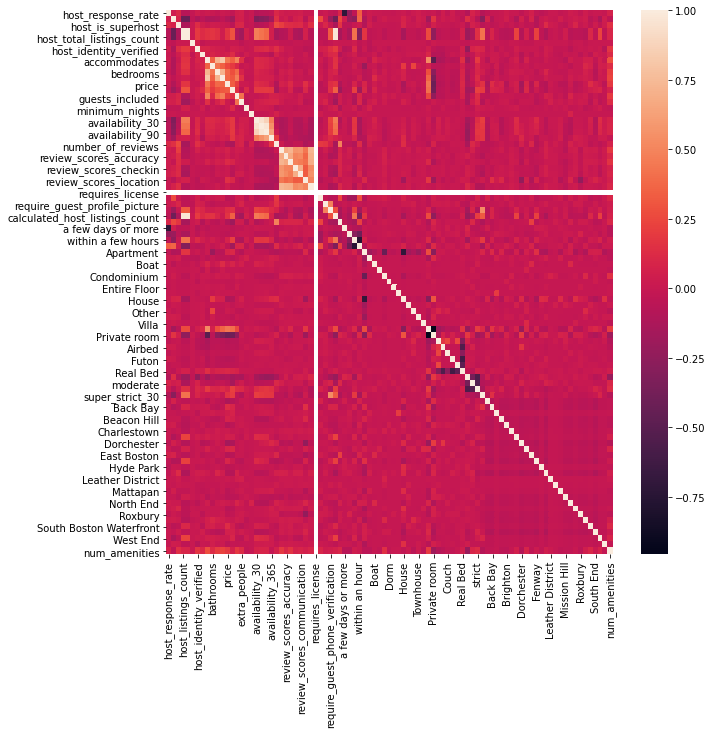

In [25]:
#Lets analyze the heatmap
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_list.corr())

## Modelling

Now we will implement machine learning models
1. Liner regression 
2. Lasso regression 
3. Ridge regression
4. Decision tree
5. Random Forest
6. XGBoost
7. Neural Network

In [26]:
y = df_list['price']
X = df_list.drop(['price','requires_license'],axis=1)

In [27]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

X=normalize(X)
y= (y-min(y))/(max(y)-min(y))

In [28]:
X.dtypes

host_response_rate           float64
host_acceptance_rate         float64
host_is_superhost            float64
host_listings_count          float64
host_total_listings_count    float64
                              ...   
South Boston Waterfront      float64
South End                    float64
West End                     float64
West Roxbury                 float64
num_amenities                float64
Length: 89, dtype: object

In [29]:
#Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

1. Linear Regression

In [30]:
linear_model = LinearRegression(normalize=True)
linear_model.fit(X_train,y_train)

LinearRegression(normalize=True)

In [31]:
y_linear_predict = linear_model.predict(X_test)

In [32]:
print("Mean squared error: ",mean_squared_error(y_linear_predict,y_test))
print("r^2 score: ",r2_score(y_test, y_linear_predict))

Mean squared error:  0.000496103219518046
r^2 score:  0.5158007423784016


2. Lasso Regression

In [33]:
lasso_model=LassoCV(normalize=True,cv=5)
lasso_model.fit(X_train,y_train)

LassoCV(cv=5, normalize=True)

In [34]:
y_lasso_predict = lasso_model.predict(X_test)

In [35]:
print("Mean squared error: ",mean_squared_error(y_lasso_predict,y_test))
print("r^2 score: ",r2_score(y_test, y_lasso_predict))

Mean squared error:  0.00048389372409664614
r^2 score:  0.5277172718149961


In [36]:
ridge_model=RidgeCV(normalize=True,cv=5)
ridge_model.fit(X_train,y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, normalize=True)

In [37]:
y_ridge_predict = ridge_model.predict(X_test)

In [38]:
print("Mean squared error: ",mean_squared_error(y_ridge_predict,y_test))
print("r^2 score: ",r2_score(y_test, y_ridge_predict))

Mean squared error:  0.0007652672707212559
r^2 score:  0.25309526367252244


2. Decision Trees

In [39]:
dtree_model=DecisionTreeRegressor(criterion="mse")
dtree_model.fit(X_train,y_train)

DecisionTreeRegressor()

In [40]:
y_dtree_predict = dtree_model.predict(X_test)

In [41]:
print("Mean squared error: ",mean_squared_error(y_dtree_predict,y_test))
print("r^2 score: ",r2_score(y_test, y_dtree_predict))

Mean squared error:  0.0026507582509674417
r^2 score:  -1.5871534929760198


In [42]:
rforest_model = RandomForestRegressor(random_state=12)
rforest_model.fit(X_train,y_train)

RandomForestRegressor(random_state=12)

In [43]:
y_rforest_predict = rforest_model.predict(X_test)

In [44]:
print("Mean squared error: ",mean_squared_error(y_rforest_predict,y_test))
print("r^2 score: ",r2_score(y_test, y_rforest_predict))

Mean squared error:  0.00042786064687108584
r^2 score:  0.5824058392893765


XGBoost

In [45]:
xgboost_model = XGBRegressor(objective='reg:squarederror')
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
y_xgboost_predict = xgboost_model.predict(X_test)

In [47]:
print("Mean squared error: ",mean_squared_error(y_xgboost_predict,y_test))
print("r^2 score: ",r2_score(y_test, y_xgboost_predict))

Mean squared error:  0.0005539598694179121
r^2 score:  0.45933235872791234


Neural Network

In [48]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout

In [49]:
nn_model = Sequential()

nn_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
nn_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
nn_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
nn_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
nn_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

nn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
nn_model.summary()

model_history=nn_model.fit(X_train, y_train,validation_split=0.33, batch_size = 10, epochs = 100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               11520     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 176,385
Trainable params: 176,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
169/169 [==============================] - 2s 12ms/step - loss: 0.0016 - mean_absolute_error: 0.0185 - v

169/169 [==============================] - 1s 6ms/step - loss: 6.4307e-04 - mean_absolute_error: 0.0110 - val_loss: 0.0013 - val_mean_absolute_error: 0.0159
Epoch 44/100
169/169 [==============================] - 1s 8ms/step - loss: 7.9558e-04 - mean_absolute_error: 0.0117 - val_loss: 5.4668e-04 - val_mean_absolute_error: 0.0133
Epoch 45/100
169/169 [==============================] - 1s 6ms/step - loss: 7.3501e-04 - mean_absolute_error: 0.0127 - val_loss: 0.0011 - val_mean_absolute_error: 0.0191
Epoch 46/100
169/169 [==============================] - 1s 6ms/step - loss: 0.0031 - mean_absolute_error: 0.0174 - val_loss: 5.8943e-04 - val_mean_absolute_error: 0.0142
Epoch 47/100
169/169 [==============================] - 1s 6ms/step - loss: 0.0011 - mean_absolute_error: 0.0128 - val_loss: 6.3739e-04 - val_mean_absolute_error: 0.0159
Epoch 48/100
169/169 [==============================] - 1s 6ms/step - loss: 9.9540e-04 - mean_absolute_error: 0.0126 - val_loss: 5.9191e-04 - val_mean_absolute

169/169 [==============================] - 1s 6ms/step - loss: 4.2450e-04 - mean_absolute_error: 0.0097 - val_loss: 6.8313e-04 - val_mean_absolute_error: 0.0146
Epoch 91/100
169/169 [==============================] - 1s 5ms/step - loss: 4.4806e-04 - mean_absolute_error: 0.0100 - val_loss: 6.2556e-04 - val_mean_absolute_error: 0.0142
Epoch 92/100
169/169 [==============================] - 1s 6ms/step - loss: 4.3547e-04 - mean_absolute_error: 0.0098 - val_loss: 7.8085e-04 - val_mean_absolute_error: 0.0149
Epoch 93/100
169/169 [==============================] - 1s 7ms/step - loss: 5.0240e-04 - mean_absolute_error: 0.0102 - val_loss: 6.8692e-04 - val_mean_absolute_error: 0.0147
Epoch 94/100
169/169 [==============================] - 1s 6ms/step - loss: 6.1937e-04 - mean_absolute_error: 0.0102 - val_loss: 9.2538e-04 - val_mean_absolute_error: 0.0163
Epoch 95/100
169/169 [==============================] - 1s 6ms/step - loss: 5.0148e-04 - mean_absolute_error: 0.0096 - val_loss: 6.3893e-04 - v

In [50]:
y_nn_predict=nn_model.predict(X_test)

In [51]:
print("Mean squared error: ",mean_squared_error(y_nn_predict,y_test))
print("r^2 score: ",r2_score(y_test, y_nn_predict))

Mean squared error:  0.0005516721594406192
r^2 score:  0.46156517526503305


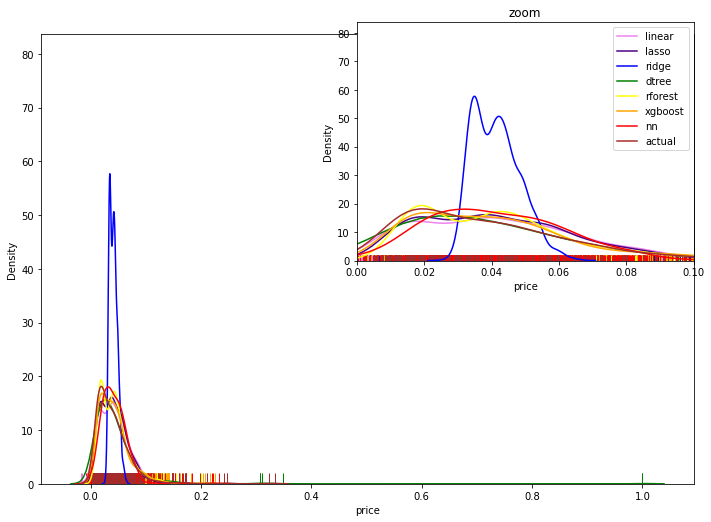

In [52]:
axis_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=axis_dims)

sns.distplot(y_linear_predict,rug=True, hist=False,label='linear',color='violet')
sns.distplot(y_lasso_predict,rug=True, hist=False,label='lasso',color='indigo')
sns.distplot(y_ridge_predict,rug=True, hist=False,label='ridge',color='blue')
sns.distplot(y_dtree_predict,rug=True, hist=False,label='dtree',color='green')
sns.distplot(y_rforest_predict,rug=True, hist=False,label='rforest',color='yellow')
sns.distplot(y_xgboost_predict,rug=True, hist=False,label='xgboost',color='orange')
sns.distplot(y_nn_predict,rug=True, hist=False,label='nn',color='red')
sns.distplot(y_test,rug=True, hist=False,label='actual',color='brown')


ax2 = plt.axes([0.5, 0.5, .4, .4], facecolor='white')
sns.distplot(y_linear_predict, ax=ax2,rug=True, hist=False,label='linear',color='violet')
sns.distplot(y_lasso_predict, ax=ax2,rug=True, hist=False,label='lasso',color='indigo')
sns.distplot(y_ridge_predict, ax=ax2,rug=True, hist=False,label='ridge',color='blue')
sns.distplot(y_dtree_predict, ax=ax2,rug=True, hist=False,label='dtree',color='green')
sns.distplot(y_rforest_predict, ax=ax2,rug=True, hist=False,label='rforest',color='yellow')
sns.distplot(y_xgboost_predict, ax=ax2,rug=True, hist=False,label='xgboost',color='orange')
sns.distplot(y_nn_predict, ax=ax2,rug=True, hist=False,label='nn',color='red')
sns.distplot(y_test, ax=ax2,rug=True, hist=False,label='actual',color='brown')

ax2.set_title('zoom')
ax2.set_xlim([0,.1])

plt.legend()
plt.show()

## Evaluation 
In this notebook we have compared different machine learning algorithms. We can see that random forest works better than other algorithms. We can increase the accuracy by doing some more hyperparameter tuning.